# Load Images and Measurements

In [1]:
import csv
from os.path import isfile
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def file_exists(file_name, img_dirs):
    for base_path in img_dirs:
        full_name = "/".join([".", base_path, file_name])
        if isfile(full_name):
            return (True, full_name)
        
    return (False, None)


def load_log_files():
    log_dirs = ('Simulator_Images', 'Simulator_Images_2')
    img_dirs = ["/".join([log_dir, "IMG"]) for log_dir in log_dirs]
    log_files = ["/".join([log_dir, "driving_log.csv"]) for log_dir in log_dirs]
    
    center_image_names = []
    center_image_measurements = []

    thres = 1
    for log_file in log_files:
        with open(log_file, 'r') as csv_file:
            filereader = csv.reader(csv_file)
            for row in filereader:
                file_name = row[0].split('\\')[-1]

                is_present, full_name = file_exists(file_name, img_dirs)
                if is_present:
                    center_image_names.append(full_name)
                    measurement = float(row[3])
                    center_image_measurements.append(measurement)

                    thres = thres + 1

                if thres > 4:
                    break

        if thres > 4:
            break

    print ("Number of images: {}".format(len(center_image_names)))
    
    return (center_image_names, center_image_measurements)


def get_train_validation_data():
    center_image_names, center_image_measurements =  load_log_files()
    train_image_samples, validation_image_samples, train_angle_samples, validation_angle_samples = train_test_split(
         center_image_names, center_image_measurements, test_size=0.33, random_state=42)
    return list(zip(train_image_samples, train_angle_samples)), list(zip(validation_image_samples, validation_angle_samples))

In [2]:
from keras.applications.imagenet_utils import preprocess_input
from sklearn.utils import shuffle
import numpy as np
import cv2

def resize_image(img, target_dim):
    num_rows = len(img[:, 0, 0])
    crop_top_rows = 55
    crop_bottom_rows = 20
    img = img[crop_top_rows:(num_rows - crop_bottom_rows), :, :]
    img = cv2.resize(img, (target_dim, target_dim))
    return img
    
def read_image(image_path, target_dim):
    img = resize_image(cv2.imread(image_path), target_dim)
    return img

def sample_generator(samples, batch_size, target_dim=224, augment_data=False):
    num_samples = len(list(samples))

    while 1:
        shuffle(samples)
        for i in range(0, num_samples, batch_size):
            batch_samples = samples[i : i + batch_size]
            
            images = []
            angles = []
            for sample in batch_samples:
                center_image = read_image(sample[0], target_dim)
                images.append(center_image)
                angles.append(sample[1])
                
                if augment_data:
                    images.append(cv2.flip(center_image, 1))
                    angles.append(-1.0 * sample[1])
        
            image_set = np.array(images, dtype=np.float32)
            image_set = preprocess_input(image_set)
            angle_set = np.array(angles, dtype=np.float32)
            
            yield shuffle(image_set, angle_set)

Using TensorFlow backend.


In [3]:
#sample_images = []
#sample_angles = []

#for img_path, angle in zip(center_image_names, center_image_measurements):
#    image = read_image(img_path)
#    sample_images.append(image)
#    sample_angles.append(angle)
    
#import random
#idx = random.randint(0, len(center_image_names))
#ex_img = sample_images[idx]

#image_shape = np.array(ex_img).shape[0:]
#print ("Image shape is {}".format(image_shape))
#plt.imshow(ex_img)

# Model Architecture

## VGG 16

In [4]:
### Reference: https://github.com/fchollet/keras/blob/master/keras/applications/vgg19.py

from keras.models import Model
from keras.layers import Flatten, Dense
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
%matplotlib inline

base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
base_model.layers.pop() # predictions
base_model.layers.pop() # fc2
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
#x = Flatten(name='custom_flatten')(x)
#x = Dense(4096, activation='relu', name='custom_fc1')(x)
x = Dense(4096, activation='relu', name='custom_fc2')(x)
predictions = Dense(1, activation='relu', name='custom_predictions')(x)

model = Model(input=base_model.input, output=predictions)

train_data, val_data = get_train_validation_data()
train_sample_size = len(train_data) * 2 # horizontal flip
val_sample_size = len(val_data)
print ("Training samples: {}".format(train_sample_size))
print ("Validation samples: {}".format(train_sample_size))

batch_size=4
train_generator = sample_generator(train_data, batch_size = batch_size, augment_data=True)
validation_generator = sample_generator(val_data, batch_size = batch_size)

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=opt)
hist = model.fit_generator(train_generator, samples_per_epoch = train_sample_size, nb_epoch=7, verbose=1,
                           validation_data=validation_generator, nb_val_samples = val_sample_size)

### plt the training and validation loss for each epoch
plt.figure(1)
loss_plot = plt.subplot(1,1,1)
loss_plot.set_title("MSE Loss")
loss_plot.plot(hist.history['loss'], label='training')
loss_plot.plot(hist.history['val_loss'], label='validation')
loss_plot.set_ylabel('MSE')
loss_plot.set_xlabel('Epoch')
loss_plot.legend(loc = 'upper right')
plt.show()

model.save('model_vgg_201708071954.h5')

Number of images: 19151
Training samples: 25662
Validation samples: 25662
Epoch 1/7
 1080/25662 [>.............................] - ETA: 1346s - loss: 549.1413

KeyboardInterrupt: 

## Custom Model

Number of images: 12
Training samples: 8
Validation samples: 8
Epoch 1/7
0s - loss: 103.6295 - acc: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 176.8303 - val_acc: 0.0000e+00 - val_precision: 0.7500 - val_recall: 5000000.5000
Epoch 2/7
0s - loss: 78.4884 - acc: 0.0000e+00 - precision: 0.1250 - recall: 0.2500 - val_loss: 86.1851 - val_acc: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/7
0s - loss: 48.8077 - acc: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 18.4403 - val_acc: 0.0000e+00 - val_precision: 0.7500 - val_recall: 5000000.5000
Epoch 4/7
0s - loss: 37.7599 - acc: 0.0000e+00 - precision: 0.2500 - recall: 2500000.2500 - val_loss: 1.9001 - val_acc: 0.0000e+00 - val_precision: 0.7500 - val_recall: 5000000.5000
Epoch 5/7
0s - loss: 18.4109 - acc: 0.0000e+00 - precision: 0.2500 - recall: 0.2500 - val_loss: 17.1925 - val_acc: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/7
0s - loss: 9.11

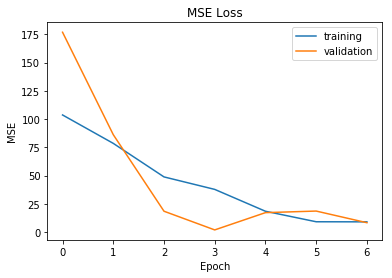

In [5]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Flatten, Dense, Lambda, Input

train_data, val_data = get_train_validation_data()
train_sample_size = len(train_data)
val_sample_size = len(val_data)
print ("Training samples: {}".format(train_sample_size))
print ("Validation samples: {}".format(train_sample_size))

batch_size=2
train_generator = sample_generator(train_data, batch_size = batch_size)
validation_generator = sample_generator(val_data, batch_size = batch_size)

inp = Input(shape=(224, 224, 3))
Max_Pixel_Value=255.0
Pixel_Mean = 0.5
x = Lambda(lambda x: (x / Max_Pixel_Value) - Pixel_Mean )(inp)
x = Flatten()(x)
predictions = Dense(1)(x)
model = Model(input=inp, output=predictions)

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer=opt)
hist = model.fit_generator(train_generator, samples_per_epoch = train_sample_size, nb_epoch=7, verbose=2,
                           validation_data=validation_generator, nb_val_samples = val_sample_size)
model.save('model.h5')